In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients

from sklearn.decomposition import PCA

In [2]:
path = "F:\JupyterNotebook_Dir\REAM _Lab\CCPP\CCPP\Folds5x2_pp.xlsx"
data = pd.read_excel(path)



data_AT = data["AT"].values;data_V = data["V"].values
data_AP = data["AP"].values;data_RH = data["RH"];data_PE = data["PE"].values
data=np.vstack((data_AT,data_V,data_AP,data_RH))
data=data.T

#data pre-processing
scaler = StandardScaler()
data_standard = scaler.fit_transform(data)

#data_PE=data_PE.T
X_train, X_test, y_train, y_test = train_test_split(data_standard, data_PE, test_size=0.33)

# Effect of individual feature

Text(15, 420, 'y=-2.171x+497.034')

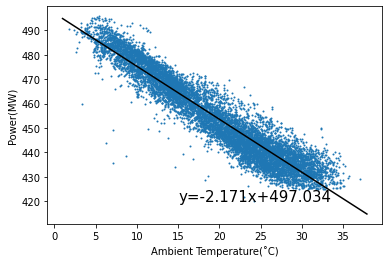

In [3]:
plt.scatter(data_AT,data_PE,s=1) ;
plt.xlabel("Ambient Temperature(˚C)");
plt.ylabel("Power(MW)");

z1 = np.polyfit(data_AT,data_PE,1)  #Linear fitting
x1 = np.arange(1, 38, 0.1)
y1 = x1 * z1[0]+z1[1]
plt.plot(x1, y1,'black')
plt.text(15,420,'y=%.3fx+%.3f'%(z1[0],z1[1]),fontsize=15)

Text(50, 420, 'y=-1.168x517.802')

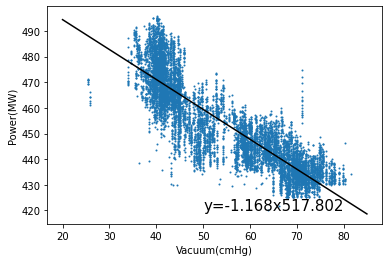

In [4]:
plt.scatter(data_V,data_PE,s=1) ;
plt.xlabel("Vacuum(cmHg)");
plt.ylabel("Power(MW)");

z2 = np.polyfit(data_V,data_PE,1)  #Linear fitting
x2 = np.arange(20, 85, 0.1)
y2 = x2 * z2[0]+z2[1]
plt.plot(x2, y2,'black')
plt.text(50,420,'y=%.3fx%.3f'%(z2[0],z2[1]),fontsize=15)

Text(1010, 420, 'y=1.490x-1055.261')

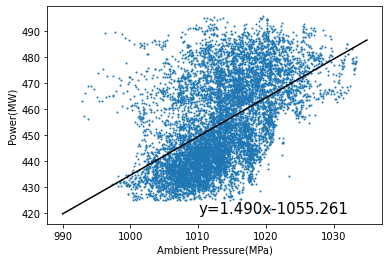

In [5]:
plt.scatter(data_AP,data_PE,s=1) ;
plt.xlabel("Ambient Pressure(MPa)");
plt.ylabel("Power(MW)");

z3 = np.polyfit(data_AP,data_PE,1)  #Linear fitting
x3 = np.arange(990, 1035, 0.1)
y3 = x3 * z3[0]+z3[1]
plt.plot(x3, y3,'black')
plt.text(1010,420,'y=%.3fx%.3f'%(z3[0],z3[1]),fontsize=15)

Text(60, 420, 'y=0.456x+420.962')

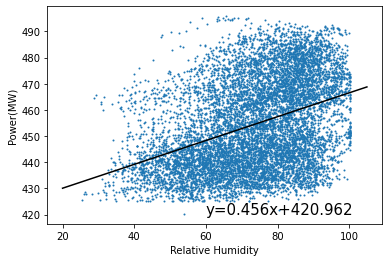

In [6]:
plt.scatter(data_RH,data_PE,s=1) ;
plt.xlabel("Relative Humidity");
plt.ylabel("Power(MW)");

z4 = np.polyfit(data_RH,data_PE,1)  #Linear fitting
x4 = np.arange(20, 105, 0.1)
y4 = x4 * z4[0]+z4[1]
plt.plot(x4, y4,'black')
plt.text(60,420,'y=%.3fx+%.3f'%(z4[0],z4[1]),fontsize=15)

# Neural Network

In [7]:
x_ts=torch.from_numpy(X_train)
y_ts=torch.from_numpy(y_train)
x_test_ts=torch.from_numpy(X_test)
y_test_ts=torch.from_numpy(y_test)
y_ts=y_ts.reshape(6410,1)
y_test_ts = y_test_ts.reshape(3158,1)
x=Variable(x_ts)

In [8]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = torch.nn.Linear(4,8) 
        self.linear2 = torch.nn.Linear(8,6)
        self.predict = torch.nn.Linear(6,1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out =self.predict(out)
        return out
    
model = Model().double()
model_pca = Model().double()

model

Model(
  (linear1): Linear(in_features=4, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=6, bias=True)
  (predict): Linear(in_features=6, out_features=1, bias=True)
)

In [9]:
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-5)
loss_func = torch.nn.MSELoss()

h_list = []
l_list = []
for epoch in range(1000):
    # forward
    y_pred = model(x)
    loss = loss_func(y_pred,y_ts)
   # print(epoch, loss.item())
    h_list.append(epoch)
    l_list.append(loss.item())
    
    # back propagation
    optimizer.zero_grad()
    loss.backward()
    
    # updating parameters
    optimizer.step()

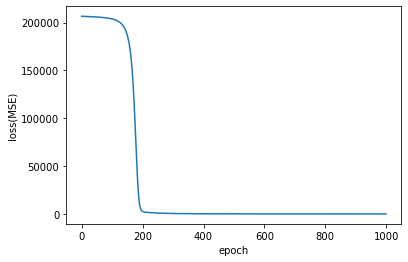

In [10]:
plt.plot(h_list, l_list)
plt.ylabel('loss(MSE)')
plt.xlabel('epoch')
plt.show()

r2_score is 0.8883984764815238
MSE is 32.55896416458842


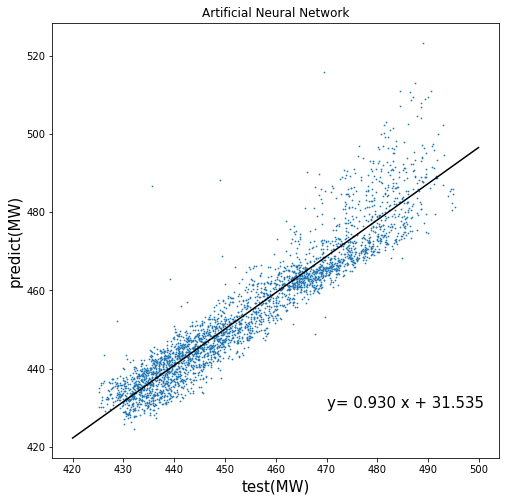

In [11]:
y_test_model=model(x_test_ts)
y_predict=y_test_model.detach().numpy()
plt.figure(figsize=(8,8))
plt.xlabel('test(MW)',fontsize=15)
plt.ylabel('predict(MW)',fontsize=15)
plt.scatter(y_test,y_predict,s=0.5)

z5 = np.polyfit(y_test,y_predict,1)  #Linear fitting
x5 = np.arange(420, 500, 0.1)
y5 = x5 * z5[0]+z5[1]
plt.plot(x5, y5,'black')
z6 = np.polyfit(y_test,y_predict,1)  #Linear fitting
plt.text(470,430,'y= %.3f x + %.3f'%(z6[0],z6[1]),fontsize=15)
plt.title('Artificial Neural Network')
r_ANN=r2_score(y_test,y_predict)
print('r2_score is %s'%r_ANN)
MSE_ANN = mean_squared_error(y_test,y_predict)
print('MSE is %s'%MSE_ANN)

# Fast Gradient Sign Method (FGSM)

In [12]:
def FGSM_attack(x_test_ts, y_test_ts, level):
    x_test_ts = Variable(x_test_ts,requires_grad=True)
    zero_gradients(x_test_ts)
    y_test_model=model(x_test_ts)
    loss = loss_func(y_test_ts,y_test_model)
    loss.backward()
    normed_grad = level * torch.sign(x_test_ts.grad.data)
    x_adv_ts = x_test_ts.data + normed_grad
    y_adv_ts = model(x_adv_ts)
    return x_adv_ts, y_adv_ts
    


In [13]:
# levels = [0.001, 0.05,0.1,0.15,0.2,0.25]
levels = [0.01,0.1,0.15,0.2,0.3,0.4]

# levels = [0.001, 0.01,0.03,0.05,0.07,0.1,0.16]
#y_ts=y_ts.reshape(3158,1)

train_scores = []
test_scores = []


for level in levels:
    x_adv_ts, y_adv_ts = FGSM_attack(x_test_ts,y_test_ts,level)
    y_p1 = y_adv_ts.detach().numpy()    
    r=r2_score(y_test,y_p1)
    train_scores.append(r)
    
    x_adv_tr, y_adv_tr = FGSM_attack(x_ts,y_ts,level)
    y_p2 = y_adv_tr.detach().numpy()    
    r=r2_score(y_train,y_p2)
    test_scores.append(r)
    

Text(0.5, 1.0, 'Attack on ANN')

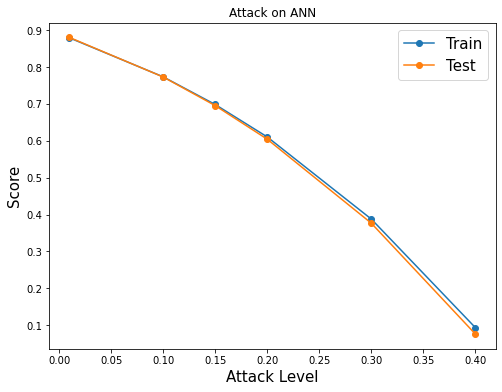

In [14]:
plt.figure(figsize=(8,6))
plt.plot(levels, train_scores, label="Train",marker='o');
plt.plot(levels, test_scores, label="Test",marker='o');
plt.xlabel("Attack Level",fontsize=15);
plt.ylabel("Score",fontsize=15);
plt.legend(prop={'size': 15})
plt.title("Attack on ANN")


# PCA Defense

In [15]:
class Model_pca(torch.nn.Module):
    def __init__(self):
        super(Model_pca,self).__init__()
        self.linear1 = torch.nn.Linear(3,12) 
        self.linear2 = torch.nn.Linear(12,8)
        self.predict = torch.nn.Linear(8,1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out =self.predict(out)
        return out
    

model_pca = Model_pca().double()

model_ae_defense = Model_pca().double()



In [16]:
def train_model_pca(x_train,model):
    pca = PCA(n_components=3)

    pca.fit(X_train)
    x_tr_pca = pca.fit_transform(X_train)
    x_tr_pca=torch.from_numpy(x_tr_pca)
    
    optimizer = torch.optim.SGD(model_pca.parameters(),lr = 1e-5)
    loss_func = torch.nn.MSELoss()

    h_list = []
    l_list = []
    for epoch in range(9000):
        # forward
        y_pred = model_pca(x_tr_pca)
        loss = loss_func(y_pred,y_ts)
       # print(epoch, loss.item())
        h_list.append(epoch)
        l_list.append(loss.item())
    
        # back propagation
        optimizer.zero_grad()
        loss.backward()
    
        # updating parameters
        optimizer.step()
    return h_list,l_list,model,x_tr_pca
    
[h_list_pca,l_list_pca,model_pca,x_tr_pca]=train_model_pca(X_train,model_pca)

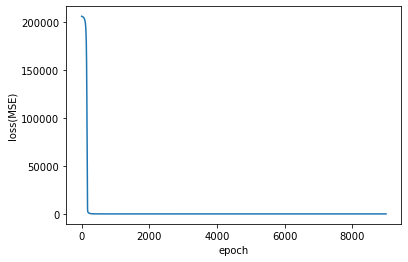

In [17]:
plt.plot(h_list_pca, l_list_pca)
plt.ylabel('loss(MSE)')
plt.xlabel('epoch')
plt.show()

0.919976614796312
MSE is 23.346263106744995


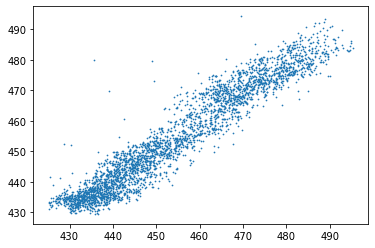

In [18]:
pca = PCA(n_components=3)
pca.fit(X_test)
x_te_pca = pca.fit_transform(X_test)
x_te_pca=torch.from_numpy(x_te_pca)
y_test_model=model_pca(x_te_pca)
y_predict=y_test_model.detach().numpy()
plt.scatter(y_test,y_predict,s=0.5)
r=r2_score(y_test,y_predict)
print(r)
MSE_ANN = mean_squared_error(y_test,y_predict)
print('MSE is %s'%MSE_ANN)

In [19]:



train_scores_pca = []
test_scores_pca = []


for level in levels:
    x_adv_ts, y_adv_ts = FGSM_attack(x_test_ts,y_test_ts,level)
    pca.fit(x_adv_ts)
    x_te_pca = pca.fit_transform(x_adv_ts)
    x_te_pca=torch.from_numpy(x_te_pca)
    y_p1 = model_pca(x_te_pca)
    y_p1 = y_p1.detach().numpy()    
    r=r2_score(y_test,y_p1)
    test_scores_pca.append(r)
    
    x_adv_tr, y_adv_tr = FGSM_attack(x_ts,y_ts,level)
    pca.fit(x_adv_tr)
    x_tr_pca = pca.fit_transform(x_adv_tr)
    x_tr_pca = torch.from_numpy(x_tr_pca)
    y_p2 = model_pca(x_tr_pca)
    y_p2 = y_p2.detach().numpy()    
    r=r2_score(y_train,y_p2)
    train_scores_pca.append(r)
    


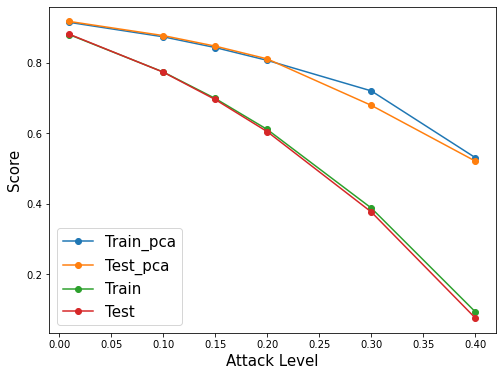

In [20]:
plt.figure(figsize=(8,6))
plt.plot(levels, train_scores_pca, label="Train_pca",marker='o');
plt.plot(levels, test_scores_pca, label="Test_pca",marker='o');
plt.plot(levels, train_scores, label="Train",marker='o');
plt.plot(levels, test_scores, label="Test",marker='o');
plt.xlabel("Attack Level",fontsize=15);
plt.ylabel("Score",fontsize=15);
plt.legend(prop={'size': 15})

In [21]:
print(test_scores_pca)
print(train_scores_pca)

[0.9166413980249865, 0.8766464163343772, 0.8467398664871997, 0.8105715501363491, 0.678894828555239, 0.5207776273110258]
[0.9140409655434685, 0.8731677968802222, 0.8427352321502177, 0.8064120654919626, 0.7198459055687216, 0.530530423601898]


# Autoencoder-based defense

Train an autoencoder (Reducing dimension from 4 to 3)

In [22]:
class autoencoder(torch.nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(torch.nn.Linear(4, 8),
                                     torch.nn.ReLU(),
                                     torch.nn.Linear(8, 8),
                                     torch.nn.ReLU(),
                                     torch.nn.Linear(8, 3))
        self.decoder = nn.Sequential(torch.nn.Linear(3, 8),
                                     torch.nn.ReLU(),
                                     torch.nn.Linear(8, 8),
                                     torch.nn.Tanh(),
                                     torch.nn.Linear(8, 4),
                                     torch.nn.Tanh())
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode
                                     
model_ae = autoencoder().double()
model_ae

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): Tanh()
  )
)

In [23]:
optimizer = torch.optim.Adam(model_ae.parameters(),lr = 1e-2,weight_decay=1e-4)
loss_ae_func = torch.nn.MSELoss()

h_ae_list = []
l_ae_list = []
for epoch in range(1000):
    # forward
    x_pred = model_ae(x)[1]
    loss = loss_ae_func(x_pred,x)
   # print(epoch, loss.item())
    h_ae_list.append(epoch)
    l_ae_list.append(loss.item())
    
    # back propagation
    optimizer.zero_grad()
    loss.backward()
    
    # updating parameters
    optimizer.step()

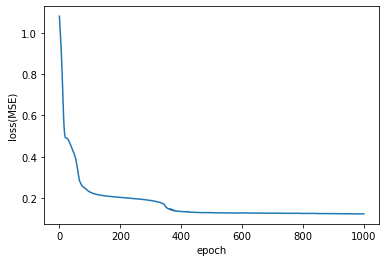

In [24]:
plt.plot(h_ae_list, l_ae_list)
plt.ylabel('loss(MSE)')
plt.xlabel('epoch')
plt.show()

Train a model with reduced dimension

In [25]:
x_ae = model_ae(x)[0]
print(x_ae.shape)
# x_aed = x_ae.clone()
# x_aed.requires_grad = True

torch.Size([6410, 3])


In [26]:
optimizer = torch.optim.SGD(model_ae_defense.parameters(),lr = 1e-5)
loss_func = torch.nn.MSELoss()

h_aeDefense_list = []
l_aeDefense_list = []
for epoch in range(1000):
    # forward
    y_pred = model_ae_defense(x_ae)
    loss = loss_func(y_pred,y_ts)
   # print(epoch, loss.item())
    h_aeDefense_list.append(epoch)
    l_aeDefense_list.append(loss.item())

    # back propagation
    optimizer.zero_grad()
    loss.backward(retain_graph=True)

    # updating parameters
    optimizer.step()

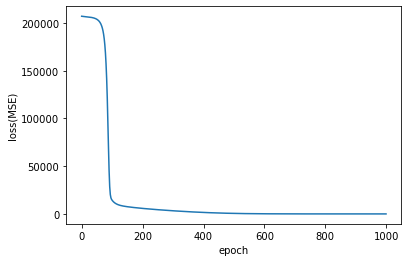

In [27]:
plt.plot(h_aeDefense_list, l_aeDefense_list)
plt.ylabel('loss(MSE)')
plt.xlabel('epoch')
plt.show()

r2_score is 0.8580766503082282
MSE is 41.30107025597913


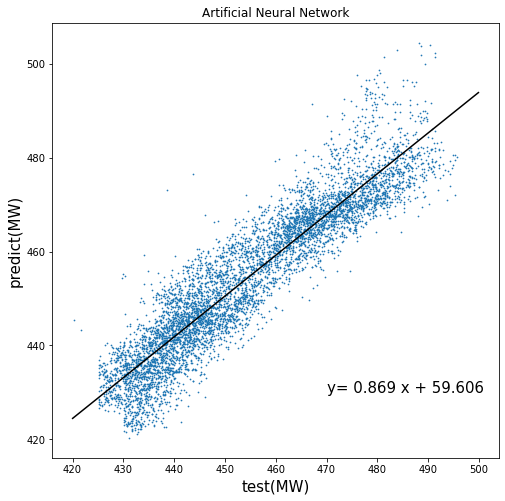

In [28]:
y_test_model=model_ae_defense(x_ae)
y_predict=y_test_model.detach().numpy()
plt.figure(figsize=(8,8))
plt.xlabel('test(MW)',fontsize=15)
plt.ylabel('predict(MW)',fontsize=15)
plt.scatter(y_train,y_predict,s=0.5)

z5 = np.polyfit(y_train,y_predict,1)  #Linear fitting
x5 = np.arange(420, 500, 0.1)
y5 = x5 * z5[0]+z5[1]
plt.plot(x5, y5,'black')
z6 = np.polyfit(y_train,y_predict,1)  #Linear fitting
plt.text(470,430,'y= %.3f x + %.3f'%(z6[0],z6[1]),fontsize=15)
plt.title('Artificial Neural Network')
r_ANN=r2_score(y_train,y_predict)
print('r2_score is %s'%r_ANN)
MSE_ANN = mean_squared_error(y_train,y_predict)
print('MSE is %s'%MSE_ANN)

In [29]:
train_scores_ae = []
test_scores_ae = []

# levels = [0.001, 0.01,0.03,0.05,0.07,0.1,0.15]
for level in levels:
    x_adv_ts, y_adv_ts = FGSM_attack(x_test_ts,y_test_ts,level)
    x_pred = model_ae(x_adv_ts)[0]
    y_p1 = model_ae_defense(x_pred)
    y_p1 = y_p1.detach().numpy()    
    r=r2_score(y_test,y_p1)
    test_scores_ae.append(r)
    
    x_adv_tr, y_adv_tr = FGSM_attack(x_ts,y_ts,level)
    x_pred = model_ae(x_adv_tr)[0]
    y_p2 = model_ae_defense(x_pred)
    y_p2 = y_p2.detach().numpy()    
    r=r2_score(y_train,y_p2)
    train_scores_ae.append(r)
#     pca.fit(x_adv_tr)
#     x_tr_pca = pca.fit_transform(x_adv_tr)
#     x_tr_pca=torch.from_numpy(x_tr_pca)
#     y_p2 = model_pca(x_tr_pca)
#     y_p2 = y_p2.detach().numpy()    
#     r=r2_score(y_train,y_p2)
#     train_scores_pca.append(r)

In [30]:
print(test_scores_ae)
print(train_scores_ae)

[0.8455628084446207, 0.7894655030799224, 0.7501034408868616, 0.7050391263409643, 0.5996592850546935, 0.4729209401878709]
[0.8533198403997466, 0.7997795033250883, 0.7617863582896325, 0.7178184590232694, 0.6128003975849134, 0.4855531094697477]


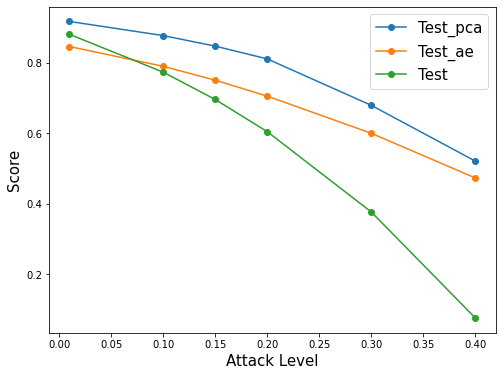

In [31]:
plt.figure(figsize=(8,6))
# plt.plot(levels, train_scores_ae, label="Train_ae",marker='o');
plt.plot(levels, test_scores_pca, label="Test_pca",marker='o');
plt.plot(levels, test_scores_ae, label="Test_ae",marker='o');
# plt.plot(levels, train_scores, label="Train",marker='o');
plt.plot(levels, test_scores, label="Test",marker='o');

plt.xlabel("Attack Level",fontsize=15);
plt.ylabel("Score",fontsize=15);
plt.legend(prop={'size': 15})

# GAN-based defense

In [32]:
# define the discriminator
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(4, 18), 
            nn.LeakyReLU(0.2),  
            nn.Linear(18, 18),  
            nn.LeakyReLU(0.2),
            nn.Linear(18, 1),
            nn.Sigmoid()  
            
        )
 
    def forward(self, x):
        x = self.dis(x)
        return x

class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(3, 18),  
            nn.ReLU(True),  
            nn.Linear(18, 18),  
            nn.ReLU(True), 
            nn.Linear(18, 18),  
            nn.ReLU(True), 
            nn.Linear(18, 4)
#             nn.Tanh()  
        )
 
    def forward(self, x):
        x = self.gen(x)
        return x


D = discriminator()
G = generator()

In [33]:
num_epoch = 6000


criterion = nn.BCELoss()  
d_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3)
g_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)


d_loss_list = []
g_loss_list = []


for epoch in range(num_epoch):
   
    num_train = x_ts.size(0)
    dim = x_ts.size(1)
    dim_noise = 3
    # =============================Discriminator training==================
    real_label = Variable(torch.ones(num_train))  # Define real samples as 1
    fake_label = Variable(torch.zeros(num_train)) # Define fake samples as 0

    # Two parts: 1. Distinguish real samples as real. 2.Distinguish fake samples as fake.
    # Compute the loss of the real samples
    real_out = D(x_ts.float())  
    d_loss_real = criterion(real_out, real_label)  # loss of real samples
    real_scores = real_out  
    # Compute the loss of the fake samples
    z = Variable(torch.randn(num_train, dim_noise))  # Generate random noise
    fake_samples = G(z).detach()  # Generating fake samples using random noise # Gradient detached as G is not updated here
    fake_out = D(fake_samples)  
    d_loss_fake = criterion(fake_out, fake_label)  # loss of fake samples
    fake_scores = fake_out 
    # Optimize the loss function
    d_loss = d_loss_real + d_loss_fake  
    d_optimizer.zero_grad()  
    d_loss.backward(d_loss)  
    d_loss_list.append(d_loss)
    d_optimizer.step()  # Update parameters

    # =============================Generator training==================
    z = Variable(torch.randn(num_train, dim_noise))  # Generate random noise
    fake_samples = G(z)  
    output = D(fake_samples)  
    g_loss = criterion(output, real_label)  # Loss of fake samples and real labels
    # bp and optimize
    g_optimizer.zero_grad()  
    g_loss.backward()  
    g_loss_list.append(g_loss)
    g_optimizer.step() 
    
    
    
    if epoch % 100 == 0:
        print('Epoch[{}/{}],d_loss:{:.6f},g_loss:{:.6f} '
              'D real: {:.6f},D fake: {:.6f}'.format(
            epoch, num_epoch, d_loss.data.item(), g_loss.data.item(),
            real_scores.data.mean(), fake_scores.data.mean()  # print the loss of real samples
        ))


F:\Anaconda\envs\python385\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([6410])) that is different to the input size (torch.Size([6410, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch[0/6000],d_loss:1.410189,g_loss:0.772232 D real: 0.453658,D fake: 0.461393
Epoch[100/6000],d_loss:0.959883,g_loss:0.953875 D real: 0.634586,D fake: 0.387752
Epoch[200/6000],d_loss:0.444365,g_loss:1.578230 D real: 0.832331,D fake: 0.208284
Epoch[300/6000],d_loss:0.310553,g_loss:2.017188 D real: 0.877717,D fake: 0.137688
Epoch[400/6000],d_loss:0.291246,g_loss:2.282367 D real: 0.884416,D fake: 0.112565
Epoch[500/6000],d_loss:0.333263,g_loss:2.354306 D real: 0.873094,D fake: 0.116154
Epoch[600/6000],d_loss:0.338301,g_loss:2.301190 D real: 0.879633,D fake: 0.114529
Epoch[700/6000],d_loss:0.419386,g_loss:2.216901 D real: 0.860680,D fake: 0.137173
Epoch[800/6000],d_loss:0.363470,g_loss:2.240810 D real: 0.875683,D fake: 0.123582
Epoch[900/6000],d_loss:0.354059,g_loss:2.247829 D real: 0.884681,D fake: 0.119441
Epoch[1000/6000],d_loss:0.375399,g_loss:2.420472 D real: 0.879611,D fake: 0.115999
Epoch[1100/6000],d_loss:0.475460,g_loss:2.423925 D real: 0.860634,D fake: 0.140371
Epoch[1200/6000]

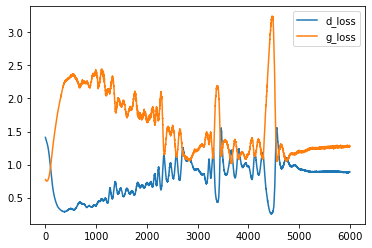

In [34]:
plt.plot(range(num_epoch),d_loss_list,label = 'd_loss')
plt.plot(range(num_epoch),g_loss_list,label = 'g_loss')
plt.legend()

In [35]:
####### A quick test on the clean input######

num_iter = 1500
loss_func = torch.nn.MSELoss()
lr = 1e2

r2_list = []

z = Variable(torch.randn(y_test_ts.shape[0], dim_noise))  # Generate random noise
z.requires_grad = True

for i in range(num_iter):
    z.retain_grad()
    x_gen = G(z)
    
#     y_gen_pred = model(x_gen.double())
#     loss = loss_func(y_test_ts,y_gen_pred) 
    
    loss = loss_func(x_test_ts,x_gen) 
    loss.backward(retain_graph=True)  
    z = z-lr*z.grad
    
    y_gen_pred = model(x_gen.double())
    r2 = r2_score(y_test_ts.detach().numpy(),y_gen_pred.detach().numpy())
    r2_list.append(r2)

0.8691451733759133


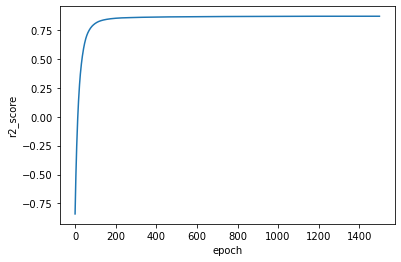

In [36]:
plt.plot(range(num_iter),r2_list)
plt.xlabel("epoch")
plt.ylabel("r2_score")
print(r2_list[-1])

In [37]:
####### GAN-based denosing######
testGAN_scores = []
num_iter = 1500

for level in levels:
    x_adv_ts, y_adv_ts = FGSM_attack(x_test_ts,y_test_ts,level)
    # GAN-based denosing
    z = Variable(torch.randn(y_test_ts.shape[0], dim_noise))  # Generate random noise
    z.requires_grad = True
    for i in range(num_iter):
        z.retain_grad()
        x_gen = G(z)



        loss = loss_func(x_adv_ts,x_gen) 
        loss.backward(retain_graph=True)  
        z = z-lr*z.grad
        
    y_gen_pred = model(x_gen.double())
    r2 = r2_score(y_test_ts.detach().numpy(),y_gen_pred.detach().numpy())
    testGAN_scores.append(r2)

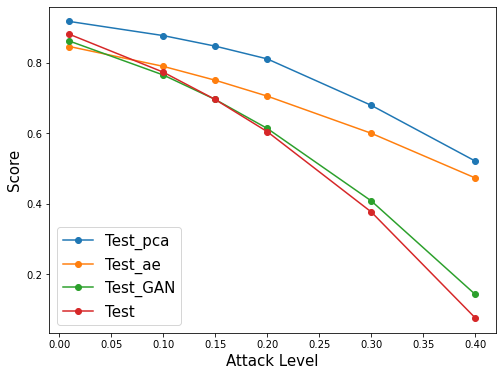

In [39]:
plt.figure(figsize=(8,6))
# plt.plot(levels, train_scores_ae, label="Train_ae",marker='o');
plt.plot(levels, test_scores_pca, label="Test_pca",marker='o');
plt.plot(levels, test_scores_ae, label="Test_ae",marker='o');
plt.plot(levels, testGAN_scores, label="Test_GAN",marker='o');
plt.plot(levels, test_scores, label="Test",marker='o');

plt.xlabel("Attack Level",fontsize=15);
plt.ylabel("Score",fontsize=15);
plt.legend(prop={'size': 15})

In [43]:
torch.save(model_ae_defense, 'model_ae_defense.pkl')

In [44]:
torch.save(model_ae, 'model_ae.pkl')

In [45]:
torch.save(model_pca, 'model_pca.pkl')